# Setup and Installations

## Required Installations For Spark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

## Required Installations for Pysparkling

In [2]:
!pip install h2o-pysparkling-3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o-pysparkling-3.1: filename=h2o_pysparkling_3.1-3.38.0.4.post1-py2.py3-none-any.whl size=162427824 sha256=c4a684b9c8d265aa18c489f44b1e19041882d84d604d3ceb6fab54d5b1bfad2d
  Stored in directory: /root/.cache/pip/wheels/a3/41/8a/6a54c86e677db4931a3d0b06167d3f5b59d1df1b9faab38d28
Successfully built h2o-pysparkling-3.1


In [3]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.8 MB/s eta 0:00:00
time: 346 µs (started: 2023-02-03 05:39:31 +00:00)


In [4]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 24.7 MB/s eta 0:00:00
time: 5.24 s (started: 2023-02-03 05:39:31 +00:00)


## Import Required Libraries

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

time: 645 µs (started: 2023-02-03 05:39:36 +00:00)


In [6]:
import h2o
import math
import findspark
import shap
import pandas as pd
import plotly.express as px
findspark.init()
from pyspark import SparkContext
from pyspark import SparkFiles
sc = SparkContext() 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()
from pysparkling import *
from h2o.automl import H2OAutoML

time: 13.7 s (started: 2023-02-03 05:39:36 +00:00)


## Load Dataset

In [7]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
spark.sparkContext.addFile(url)
covid_df = spark.read.csv(SparkFiles.get("owid-covid-data.csv"), header=True, inferSchema= True)
print("Shape of the dataset: {} rows, {} columns".format(covid_df.count(), len(covid_df.columns)))
covid_df.show()

Shape of the dataset: 254654 rows, 67 columns
+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+----------------

## Exploratory Data Analysis

# ML Models

## Multivariate Time Series ML

## Cluster Analysis

## Regression Models - Predict Deaths For a Country

### Dataset Preparation

In [8]:
#Only select demographocs/mortality columns from covid_df
covid_df_demo_mort = covid_df.select('continent', 'location', 'date',
'new_cases_smoothed', 'new_deaths_smoothed', 'reproduction_rate', 
'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita', 
'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 
'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy', 
'human_development_index', 'population')

time: 150 ms (started: 2023-02-03 05:40:16 +00:00)


In [9]:
#Converting Timestamp String to DateType
covid_df_demo_mort = covid_df_demo_mort.withColumn('date_dt', 
to_date(unix_timestamp(col('date'), 'yyyy-MM-dd').cast("timestamp")))

time: 648 ms (started: 2023-02-03 05:40:16 +00:00)


In [10]:
# #Drop records that have NaN in specified columns
covid_df_demo_mort = covid_df_demo_mort.na.drop(subset=['location', 'continent', 
'date_dt', 'date', 'new_cases_smoothed', 'new_deaths_smoothed'])

time: 44.8 ms (started: 2023-02-03 05:40:17 +00:00)


In [11]:
# #Remove records pertaining to Kosovo as it only has info on cases and population
covid_df_demo_mort = covid_df_demo_mort.where(covid_df_demo_mort.location != 'Kosovo')

time: 39.1 ms (started: 2023-02-03 05:40:17 +00:00)


In [12]:
covid_df_demo_mort = covid_df_demo_mort.withColumn("population_density_updated", 
expr("CASE WHEN population_density IS NULL AND population IS NOT NULL AND location = 'Anguilla' THEN ROUND(population/102,1) " + 
     "WHEN population_density IS NULL AND population IS NOT NULL AND location = 'Bonaire Sint Eustatius and Saba' THEN ROUND(population/328,1) " +
     "WHEN population_density IS NULL AND population IS NOT NULL AND location = 'Cook Islands' THEN ROUND(population/236.7,1) " +
     "WHEN population_density IS NULL AND population IS NOT NULL AND location = 'Montserrat' THEN ROUND(population/102,1) " +
     "WHEN population_density IS NULL AND population IS NOT NULL AND location = 'Saint Pierre and Miquelon' THEN ROUND(population/242,1) " +
     "WHEN population_density IS NULL AND population IS NOT NULL AND location = 'South Sudan' THEN ROUND(population/644329,1) " +
     "WHEN population_density IS NULL AND population IS NOT NULL AND location = 'Syria' THEN ROUND(population/185180,1) " +
     "WHEN population_density IS NULL AND population IS NOT NULL AND location = 'Taiwan' THEN ROUND(population/36197,1) " +
     "WHEN population_density IS NULL AND population IS NOT NULL AND location = 'Wallis and Futuna' THEN ROUND(population/274,1) " +
     "ELSE population_density END"))

time: 471 ms (started: 2023-02-03 05:40:17 +00:00)


In [13]:
#For columns 'hospital_beds_per_thousand', 'male_smokers', and 'female_smokers', fill NaN values with 0
covid_df_demo_mort = covid_df_demo_mort.na.fill(value=0,
subset=['hospital_beds_per_thousand', 'male_smokers', 'female_smokers'])

time: 217 ms (started: 2023-02-03 05:40:17 +00:00)


In [14]:
#Remove records with null values in any column
covid_df_demo_mort = covid_df_demo_mort.na.drop(subset=["continent","location",
"date", "new_cases_smoothed", "new_deaths_smoothed", "reproduction_rate", "median_age",
"aged_65_older", "gdp_per_capita", "cardiovasc_death_rate", "diabetes_prevalence", 
"female_smokers", "male_smokers", "hospital_beds_per_thousand", "life_expectancy", 
"human_development_index", "population", "date_dt", "population_density_updated"])

time: 93.6 ms (started: 2023-02-03 05:40:18 +00:00)


In [15]:
#Extract month and year from 'date' column
covid_df_demo_mort = covid_df_demo_mort.withColumn('month', month(covid_df_demo_mort.date_dt))
covid_df_demo_mort = covid_df_demo_mort.withColumn('year', year(covid_df_demo_mort.date_dt))

time: 105 ms (started: 2023-02-03 05:40:18 +00:00)


In [16]:
#Drop 'date', 'date_dt', 'continent', 'location' from dataset
covid_df_demo_mort_final = covid_df_demo_mort.drop('date', 'population_density', 'date_dt', 'continent', 'location')

time: 49.3 ms (started: 2023-02-03 05:40:18 +00:00)


In [17]:
covid_df_demo_mort_final.show()

+------------------+-------------------+-----------------+----------+-------------+--------------+---------------------+-------------------+--------------+------------+--------------------------+---------------+-----------------------+-----------+--------------------------+-----+----+
|new_cases_smoothed|new_deaths_smoothed|reproduction_rate|median_age|aged_65_older|gdp_per_capita|cardiovasc_death_rate|diabetes_prevalence|female_smokers|male_smokers|hospital_beds_per_thousand|life_expectancy|human_development_index| population|population_density_updated|month|year|
+------------------+-------------------+-----------------+----------+-------------+--------------+---------------------+-------------------+--------------+------------+--------------------------+---------------+-----------------------+-----------+--------------------------+-----+----+
|            11.429|              0.571|             1.51|      18.6|        2.581|      1803.987|              597.029|               9.59|  

In [18]:
print("Shape of final dataset: {} rows, {} columns".format(covid_df_demo_mort_final.count(), len(covid_df_demo_mort_final.columns)))

Shape of final dataset: 170158 rows, 17 columns
time: 3.2 s (started: 2023-02-03 05:40:19 +00:00)


### H20 AutoML Regression Models

In [19]:
(train_data, test_data) = covid_df_demo_mort_final.randomSplit([0.75, 0.25],0)

print("Records for training: " + str(train_data.count()))
print("Records for evaluation: " + str(test_data.count()))

Records for training: 127385
Records for evaluation: 42773
time: 7.66 s (started: 2023-02-03 05:40:22 +00:00)


In [20]:
#Setup H2O configurations
hc = H2OContext.getOrCreate()

Connecting to H2O server at http://56d89c5bd8d4:54323 ... successful.


H2O_cluster_uptime:,16 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,"28 days, 12 hours and 14 minutes"
H2O_cluster_name:,sparkling-water-root_local-1675402788133
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,910 Mb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.38.0.4-1-3.1
 * H2O name: sparkling-water-root_local-1675402788133
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.28.0.12,54321)
  ------------------------

  Open H2O Flow in browser: http://56d89c5bd8d4:54323 (CMD + click in Mac OSX)

    
time: 17.8 s (started: 2023-02-03 05:40:30 +00:00)


In [21]:
#Convert DF to H2O Frame
trainH2O = hc.asH2OFrame(train_data)
testH2O = hc.asH2OFrame(test_data)

time: 15.2 s (started: 2023-02-03 05:40:48 +00:00)


In [22]:
x = trainH2O.columns
y = "new_deaths_smoothed"
x.remove(y)

# Defaults to 5 fold cross-val
aml = H2OAutoML(max_runtime_secs = 1800, seed = 1)
aml.train(x=x, y=y, training_frame=trainH2O)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,3.6101558,0.0622175,3.6001823,3.6390264,3.5187464,3.68864,3.6041842
mean_residual_deviance,192.01778,25.745533,166.67181,219.15582,181.03728,220.16676,173.05725
mse,192.01778,25.745533,166.67181,219.15582,181.03728,220.16676,173.05725
null_deviance,704118590.0000000,24035624.0000000,714574080.0000000,707568770.0000000,662530820.0000000,724161600.0000000,711757820.0000000
r2,0.9930536,0.0008734,0.9940466,0.9920963,0.9930024,0.9923044,0.9938183
residual_deviance,4891000.0,645855.56,4254131.5,5592418.0,4636002.5,5572641.0,4399807.5
rmse,13.832441,0.9228743,12.910144,14.803912,13.455009,14.838017,13.155123
rmsle,nan,0.0,nan,nan,nan,nan,nan


time: 30min 3s (started: 2023-02-03 05:41:03 +00:00)


In [23]:
# View the AutoML Leaderboard
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb.head(10)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_2_AutoML_1_20230203_54103,13.8556,191.977,3.60997,nan,191.977,1596,0.043103,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20230203_54103,13.8645,192.224,3.6105,nan,192.224,1267,0.041085,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20230203_54103,13.987,195.637,3.64634,nan,195.637,1169,0.044945,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20230203_54103,13.9992,195.978,3.64914,nan,195.978,1997,0.03622,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20230203_54103,15.1666,230.026,3.81418,nan,230.026,2699,0.194424,StackedEnsemble
XGBoost_1_AutoML_1_20230203_54103,15.8159,250.144,3.92707,nan,250.144,37901,0.017311,XGBoost
GBM_4_AutoML_1_20230203_54103,16.096,259.083,4.55223,nan,259.083,12430,0.0167,GBM
XGBoost_2_AutoML_1_20230203_54103,16.5716,274.619,4.57873,nan,274.619,6597,0.006386,XGBoost
XGBoost_grid_1_AutoML_1_20230203_54103_model_1,19.3653,375.014,5.77099,nan,375.014,1197,0.002089,XGBoost
GBM_3_AutoML_1_20230203_54103,19.5163,380.888,6.14733,nan,380.888,11961,0.024814,GBM


time: 1min 21s (started: 2023-02-03 06:11:06 +00:00)


In [24]:
#plotting the variable importance for StackedEnsemble Models
se_var_imp_df = aml.leader.permutation_importance(trainH2O, use_pandas=True)
se_var_imp_df = se_var_imp_df.sort_values(by=['Scaled Importance'])
fig = px.bar(se_var_imp_df, x="Scaled Importance", orientation='h',
             title="Variable Importance For Best StackedEnsemble Model").update_layout(title_x=0.5)
fig.show()

time: 8.69 s (started: 2023-02-03 06:12:28 +00:00)


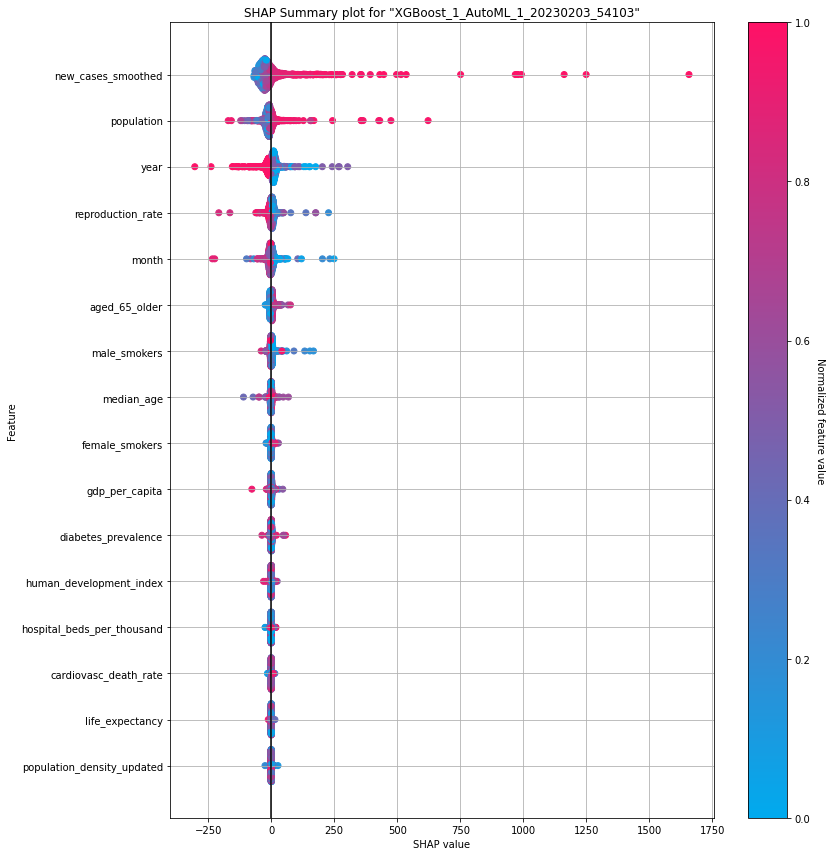

time: 42.9 s (started: 2023-02-03 06:12:37 +00:00)


In [25]:
#Generate SHAP plots for XGBoost Model
xgb = aml.get_best_model(algorithm="xgboost")
xgb.shap_summary_plot(testH2O)

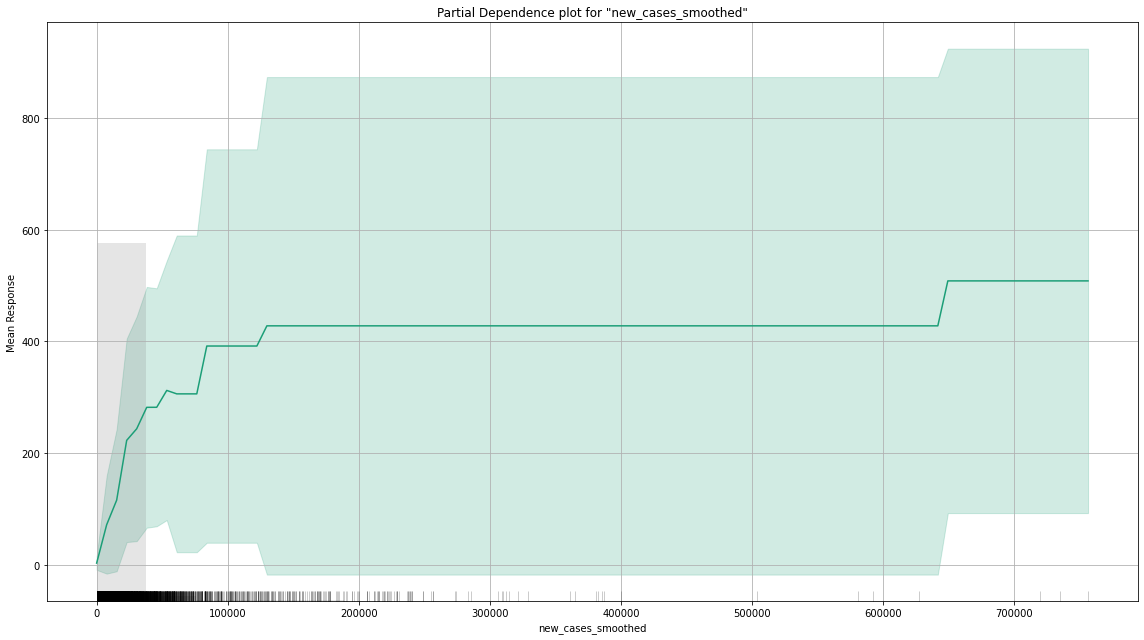

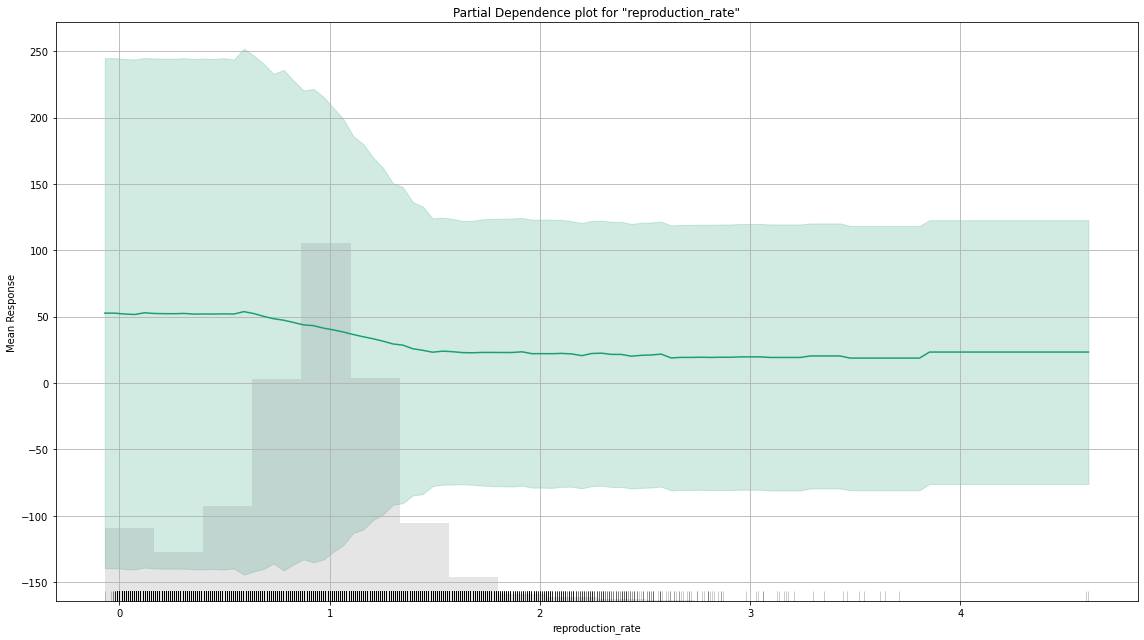

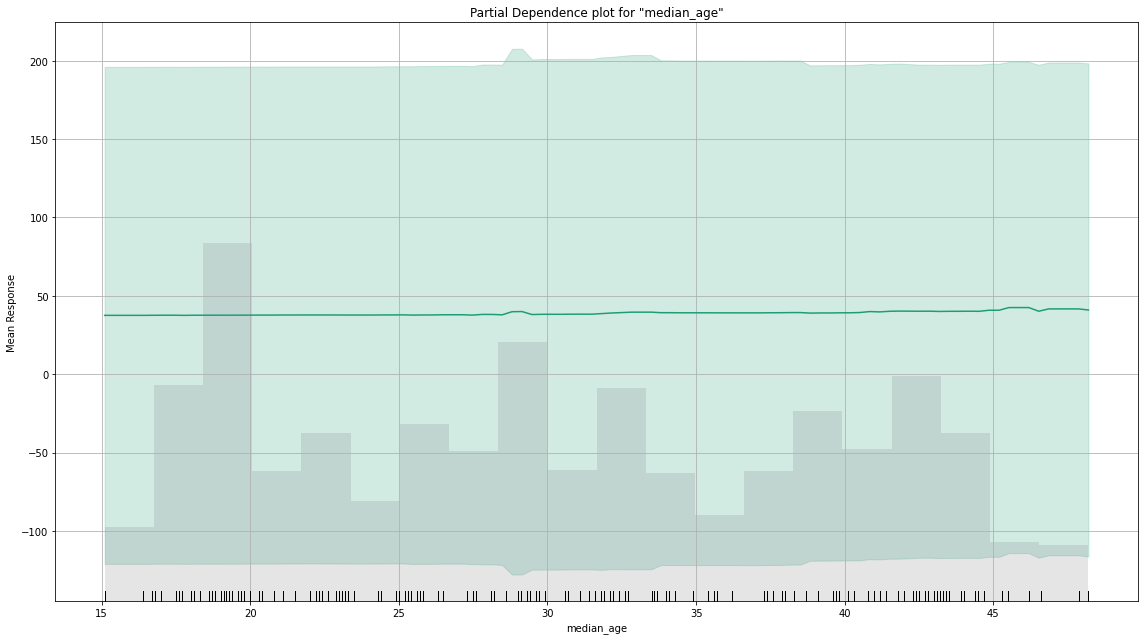

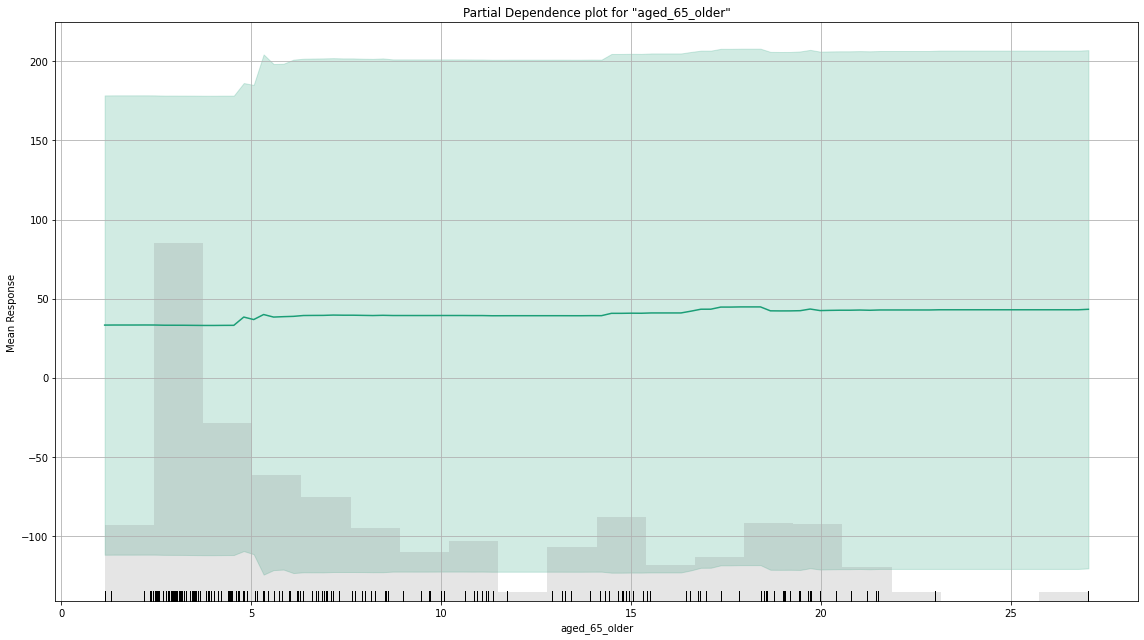

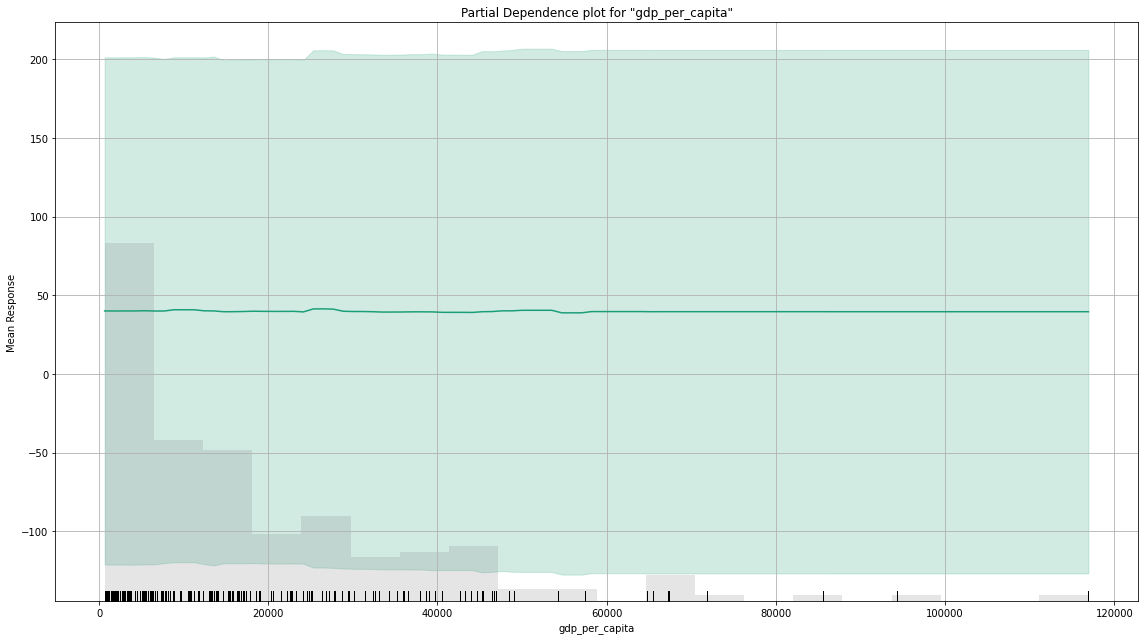

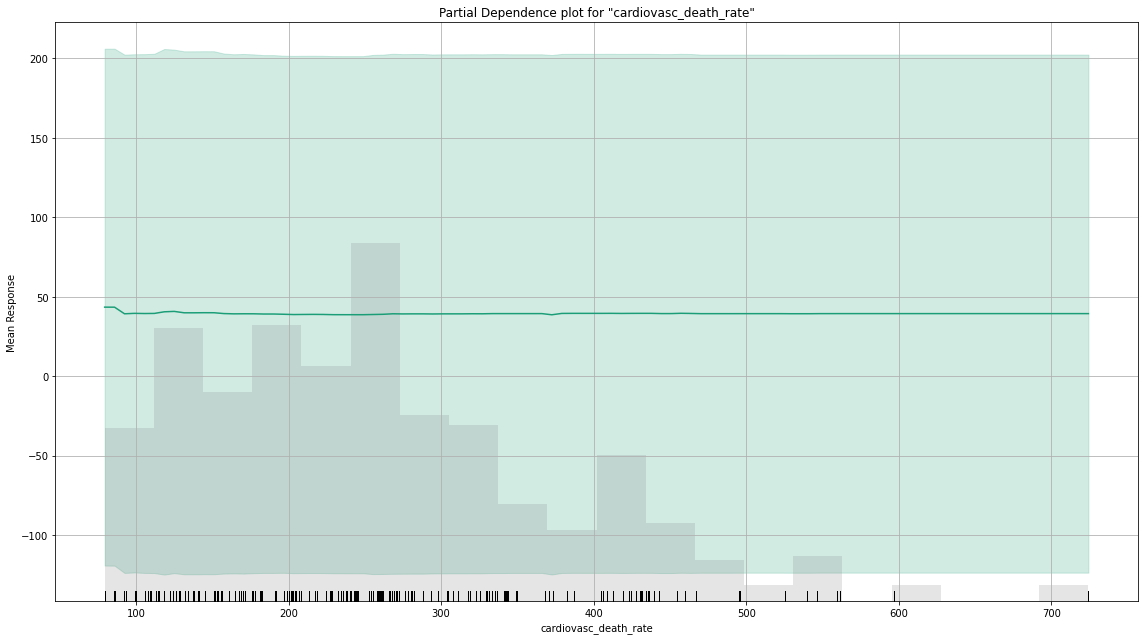

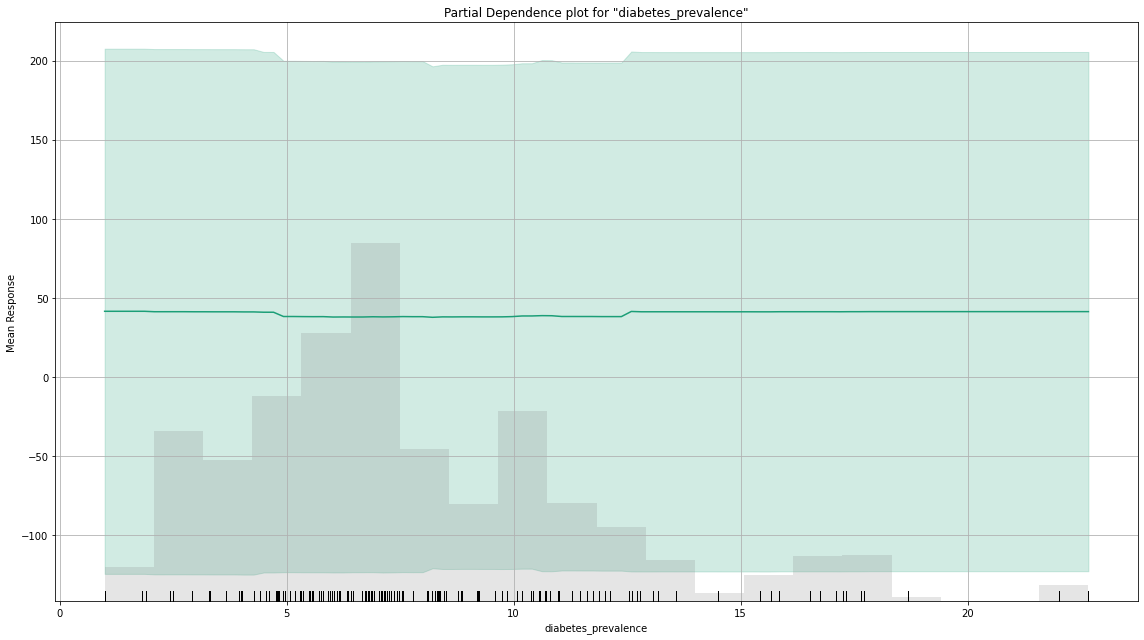

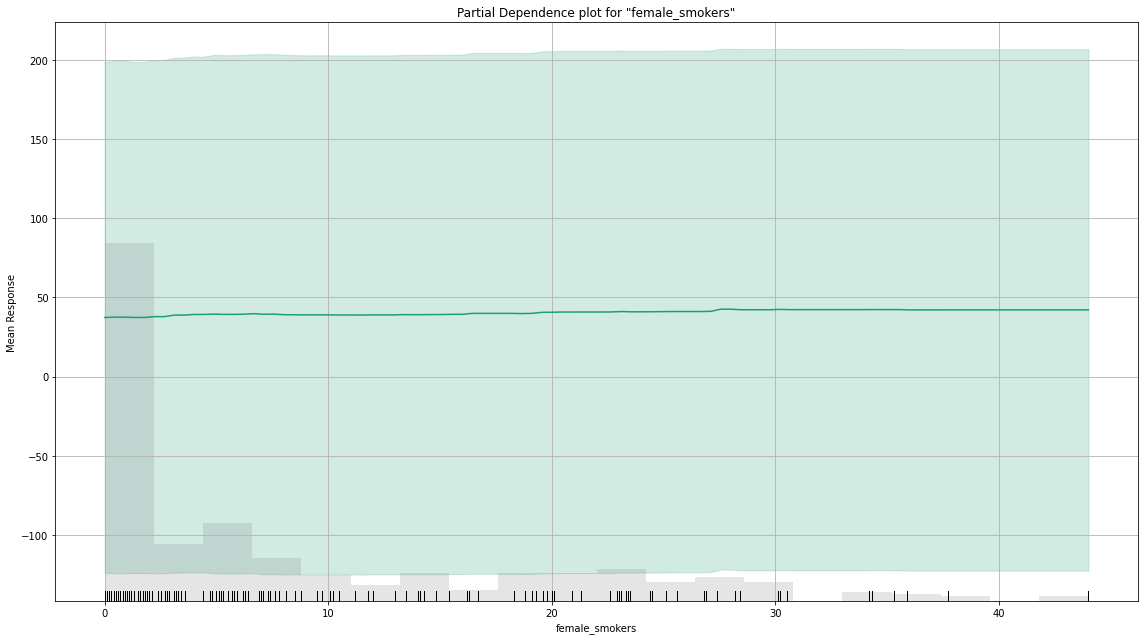

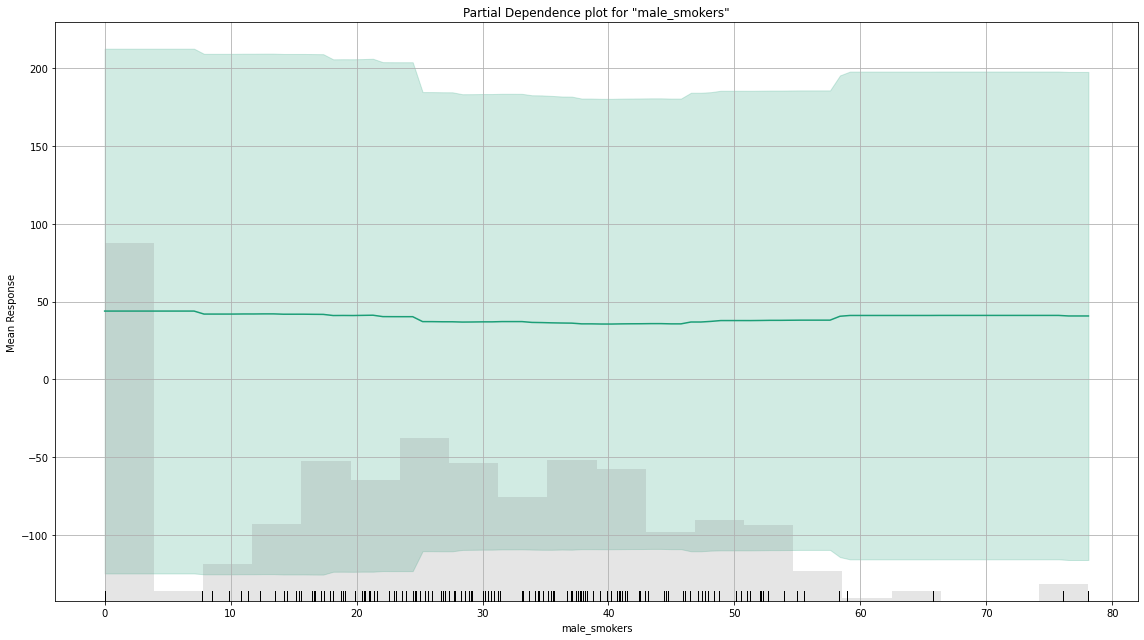

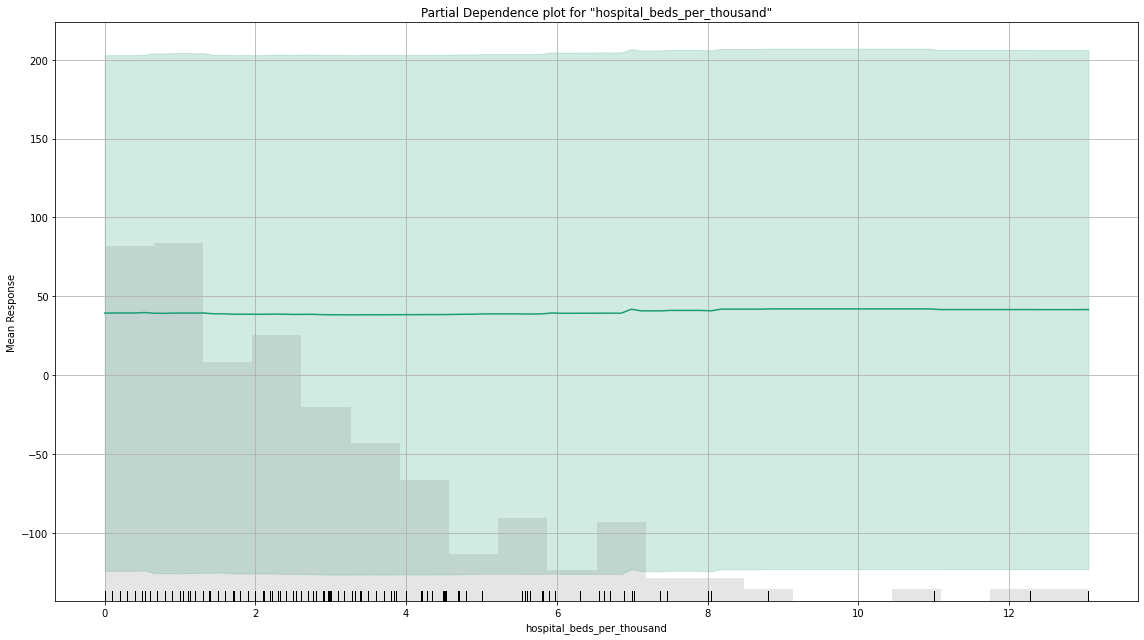

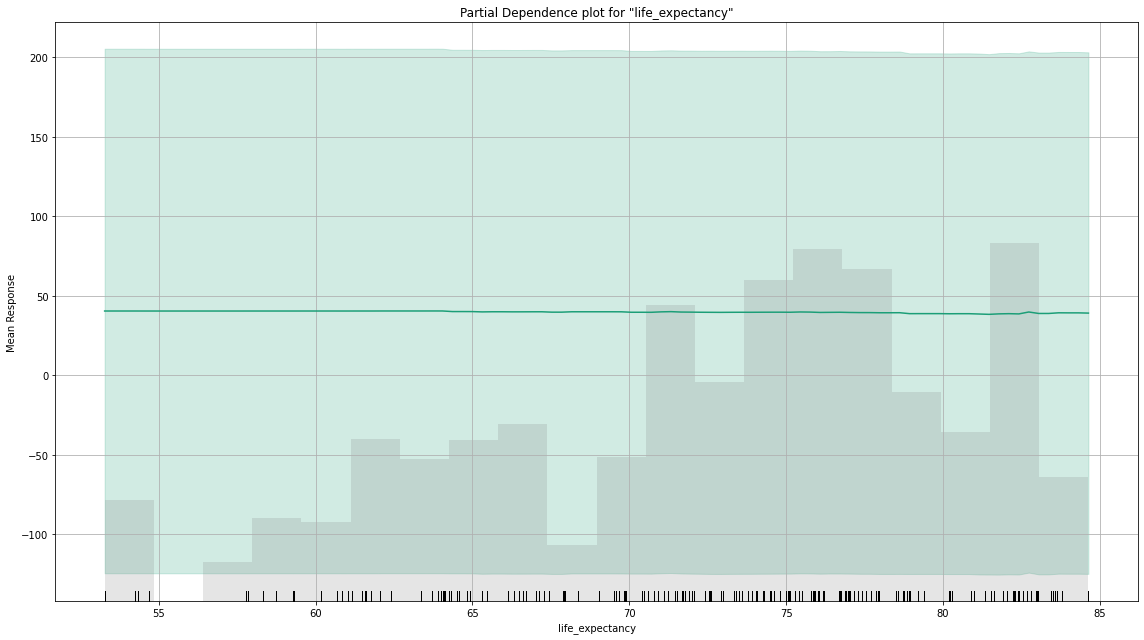

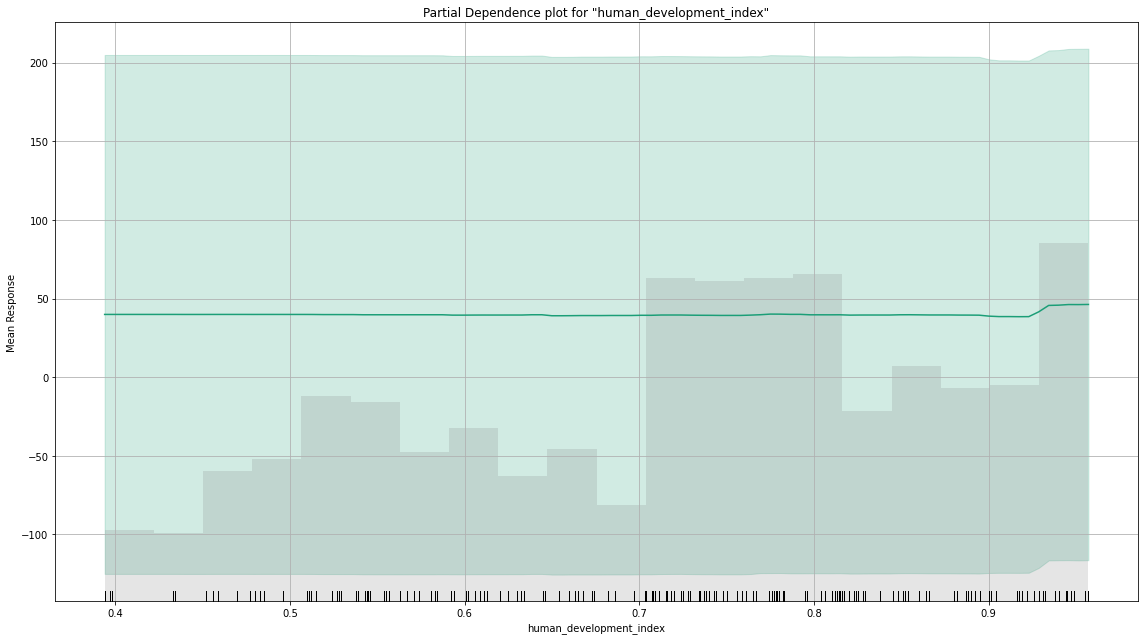

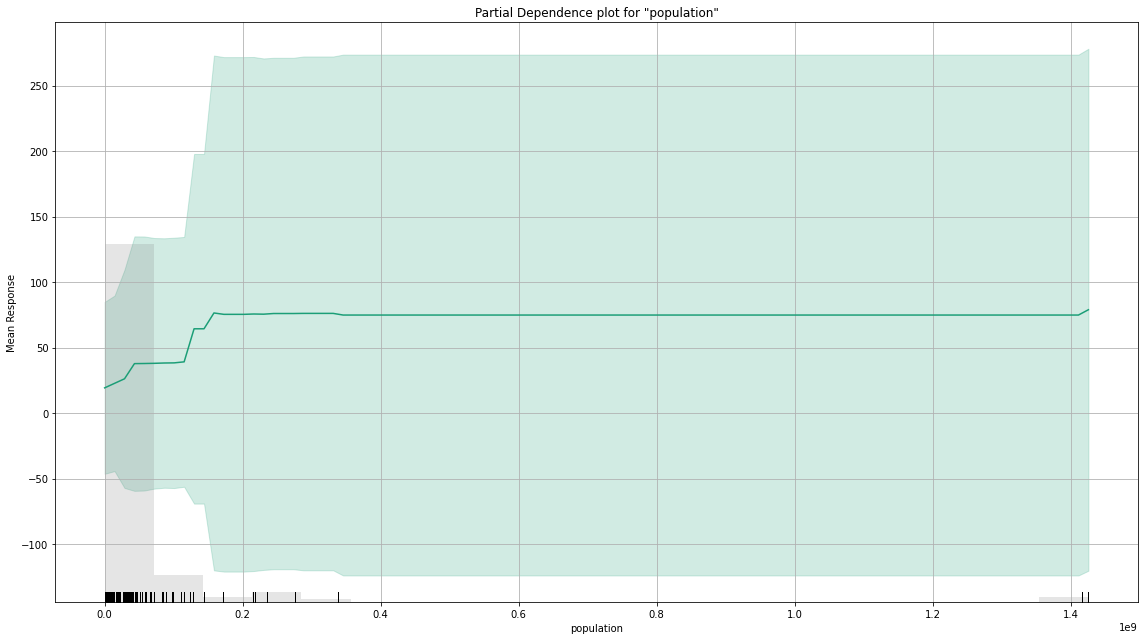

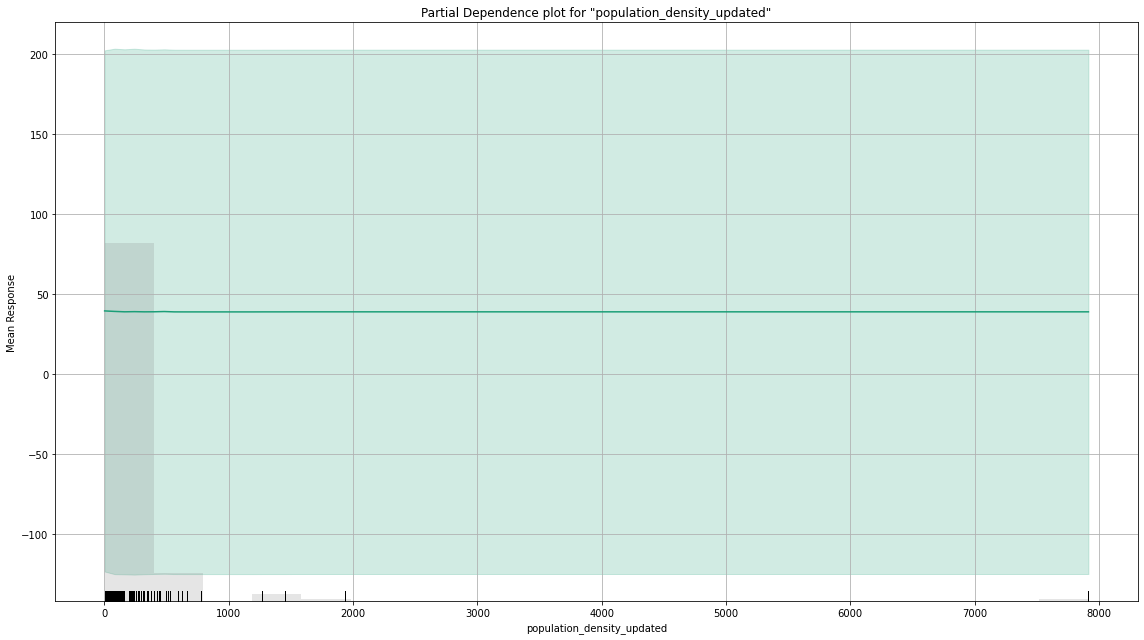

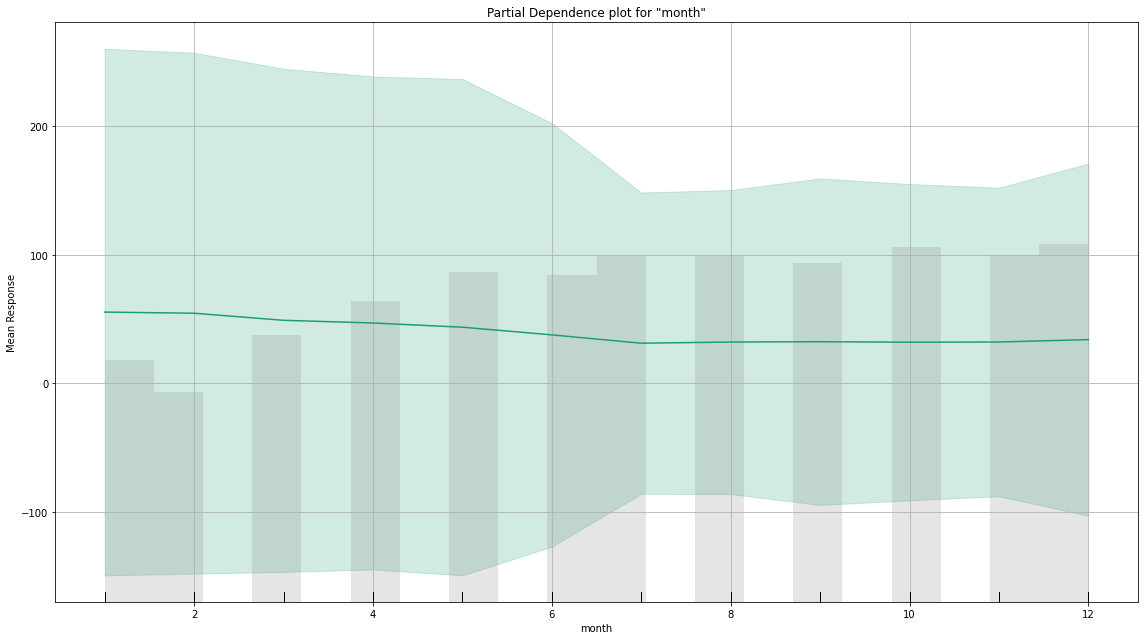

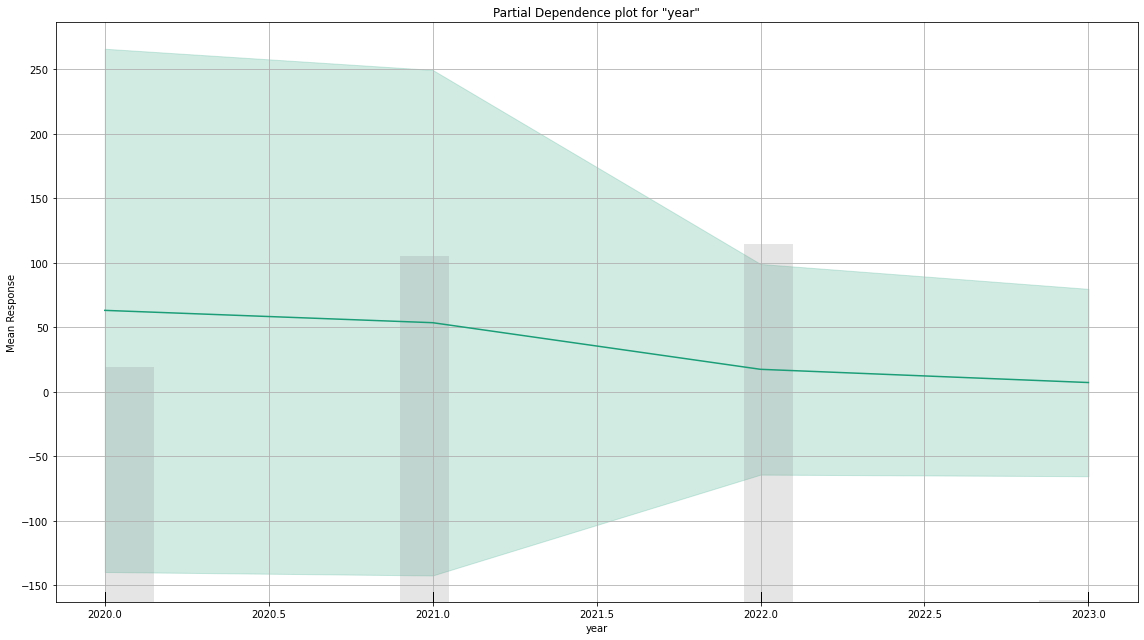

time: 19min 41s (started: 2023-02-03 06:13:19 +00:00)


In [26]:
#PDP Plots
for i in x:
  pd_plot = xgb.pd_plot(testH2O, i)
  pd_plot

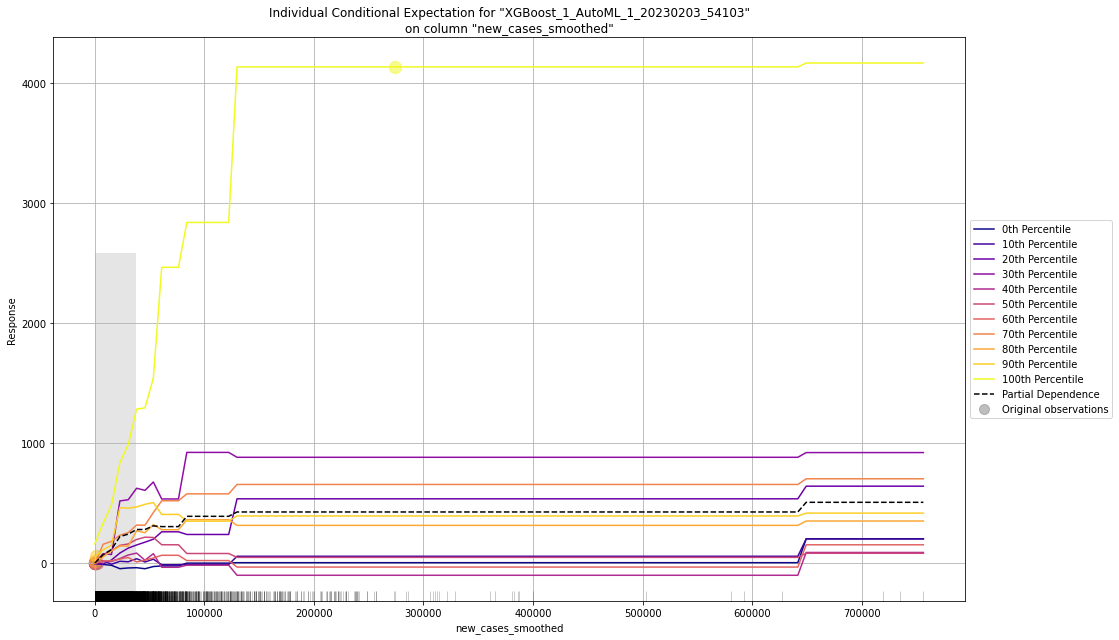

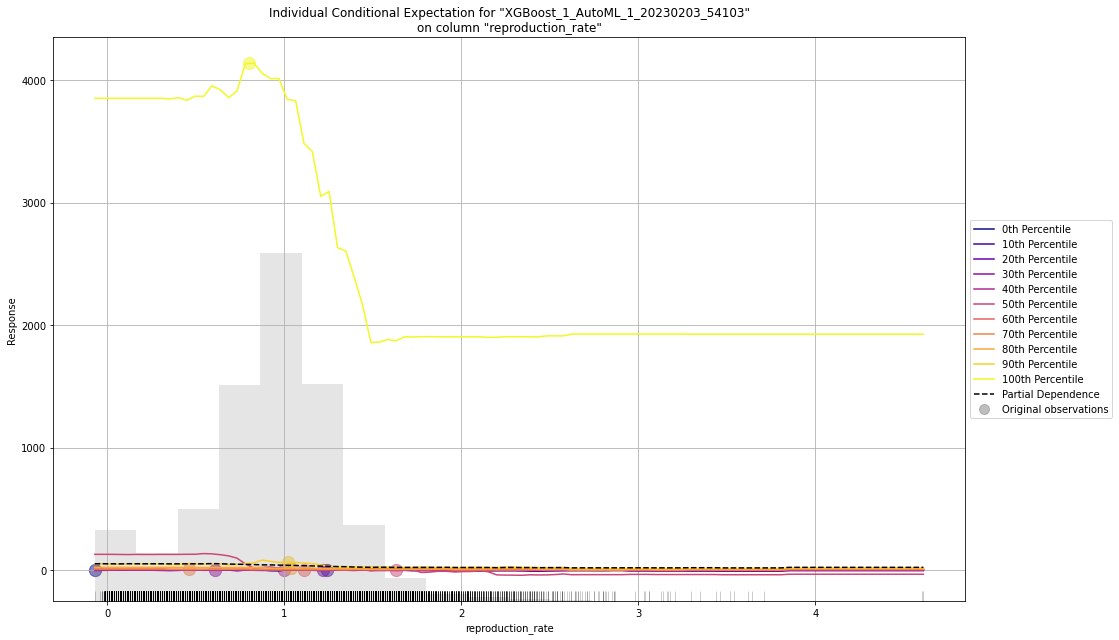

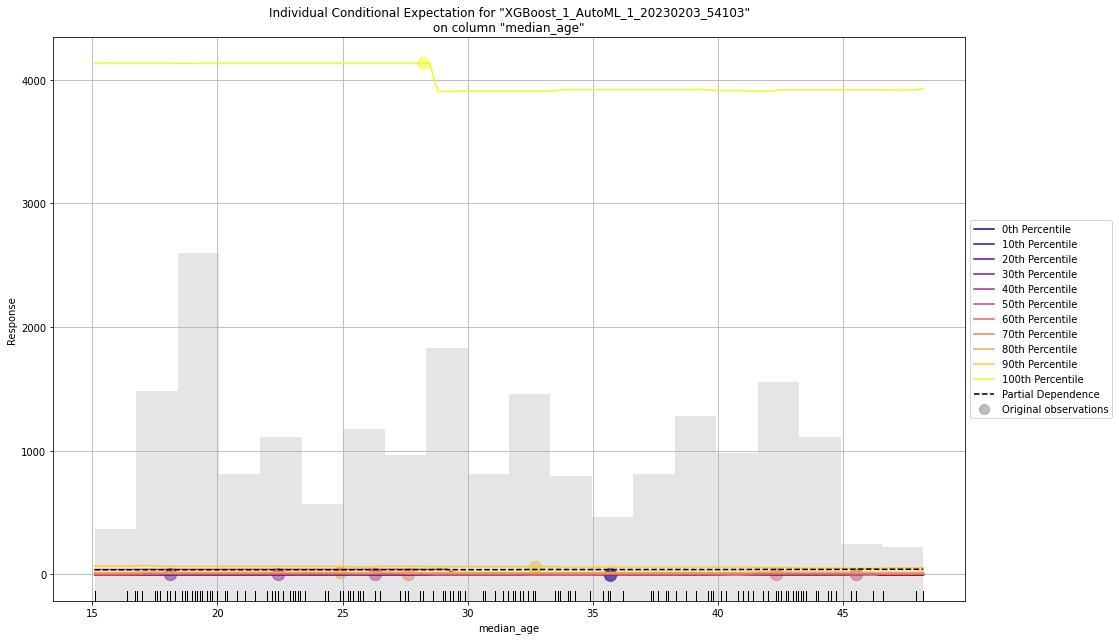

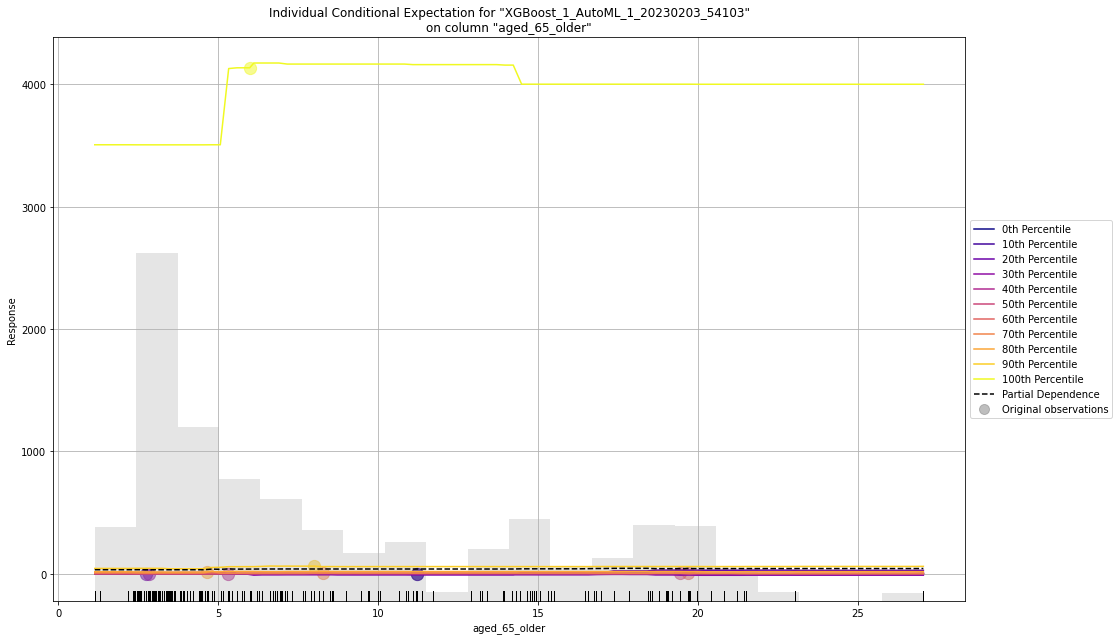

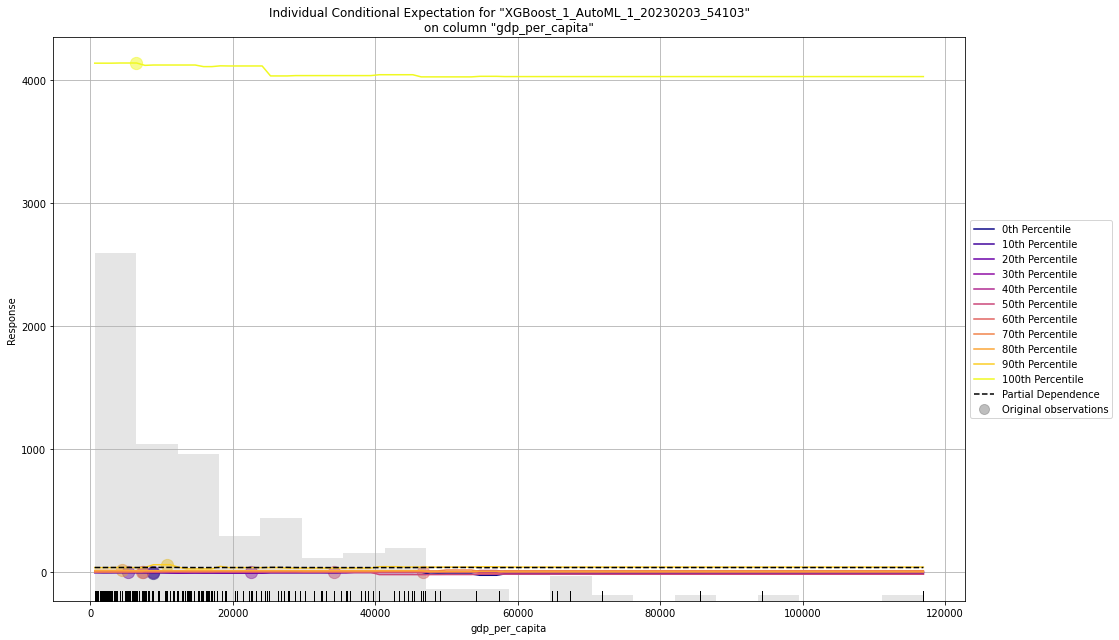

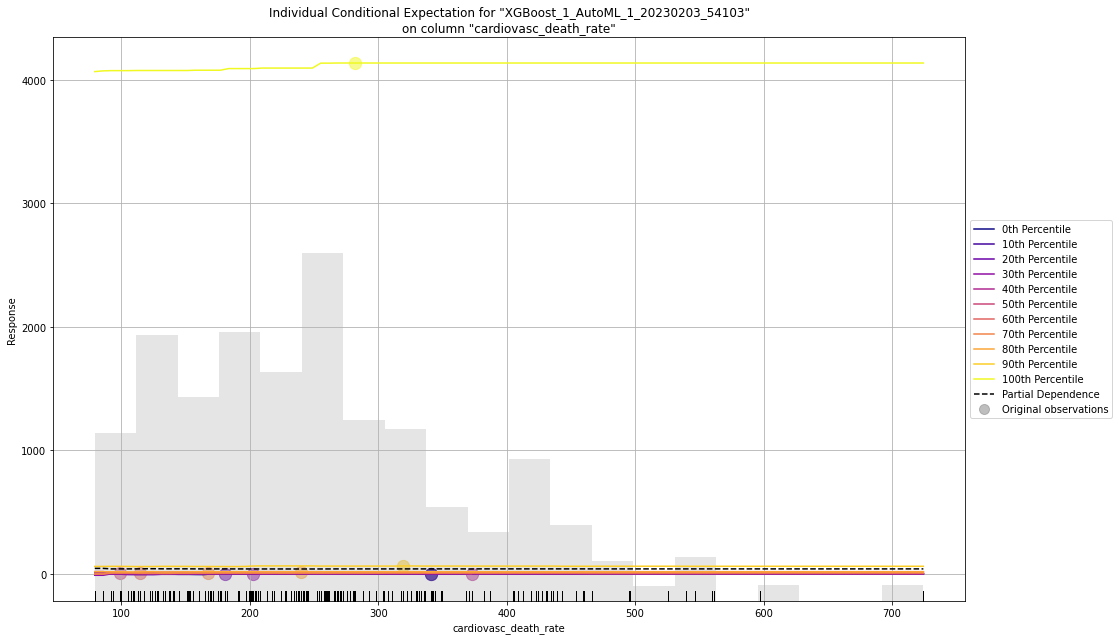

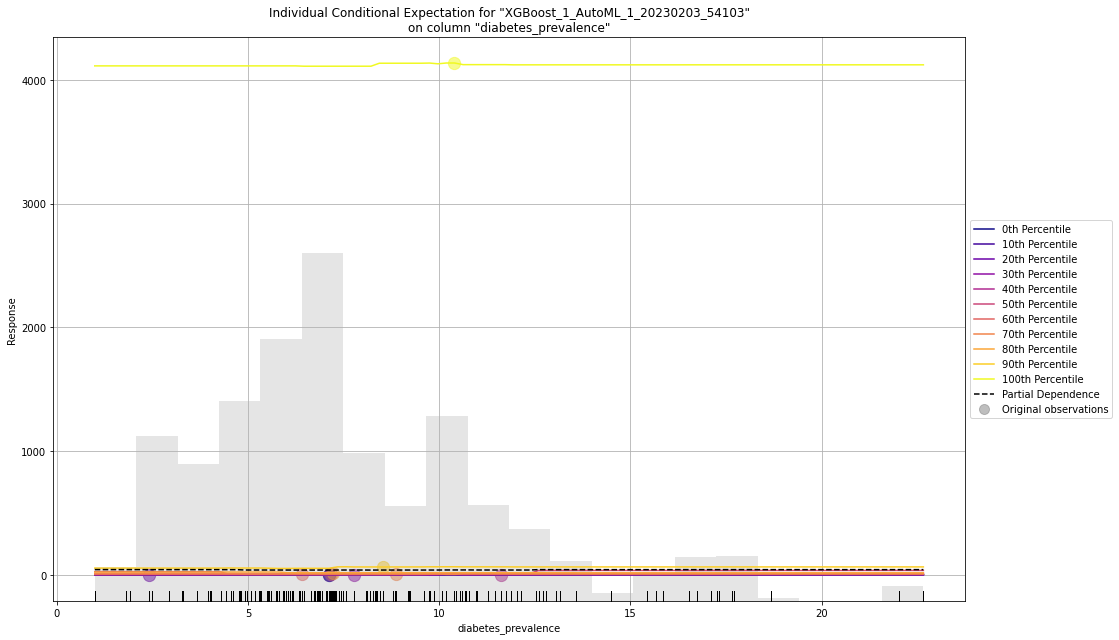

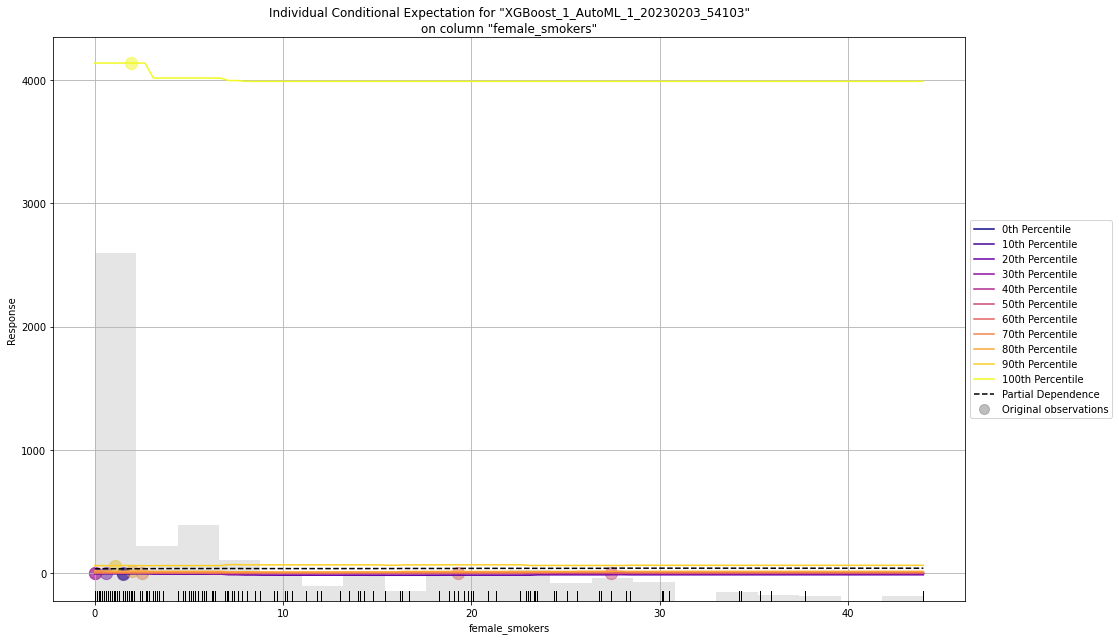

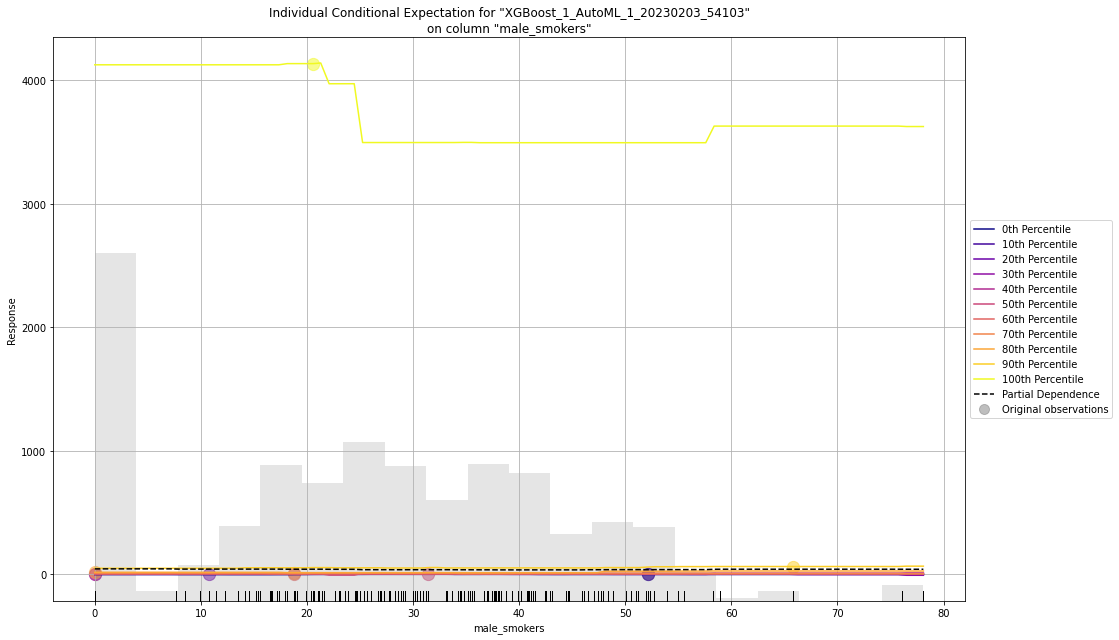

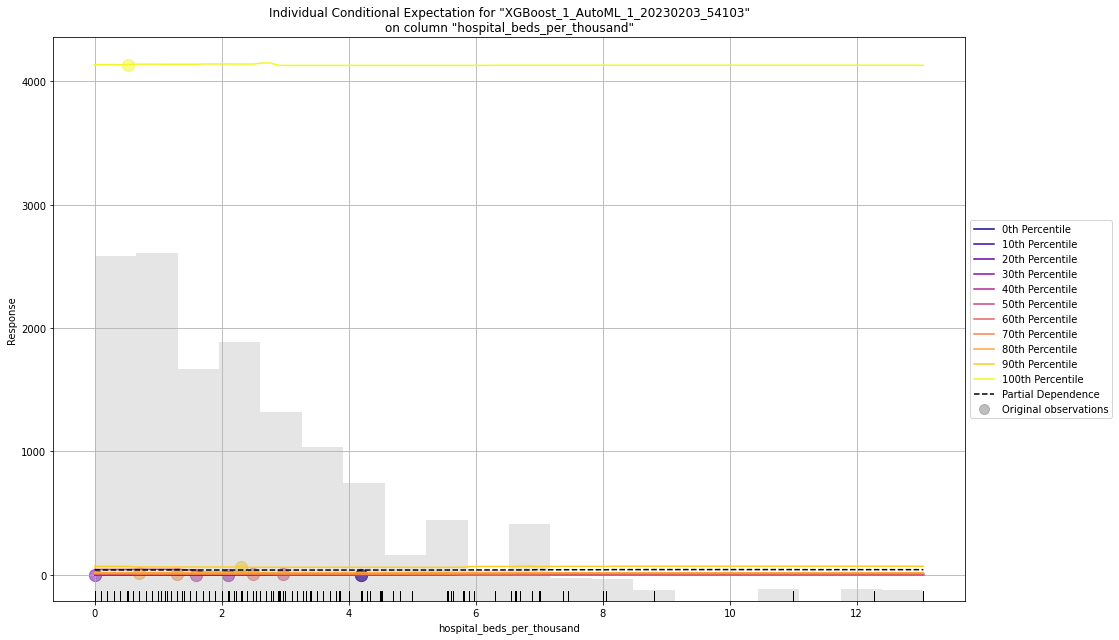

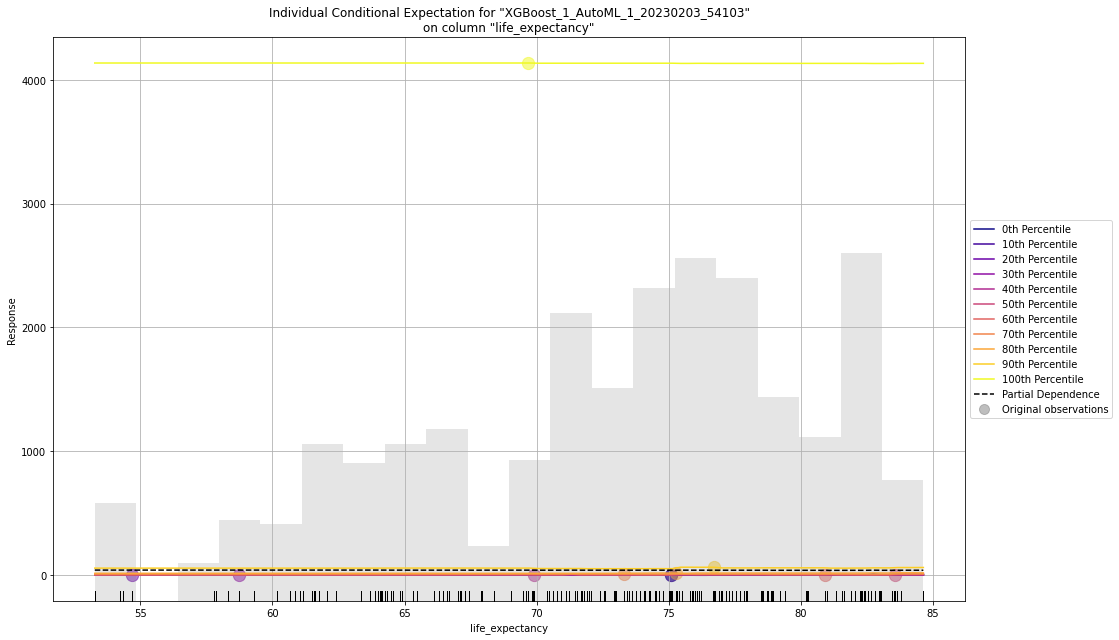

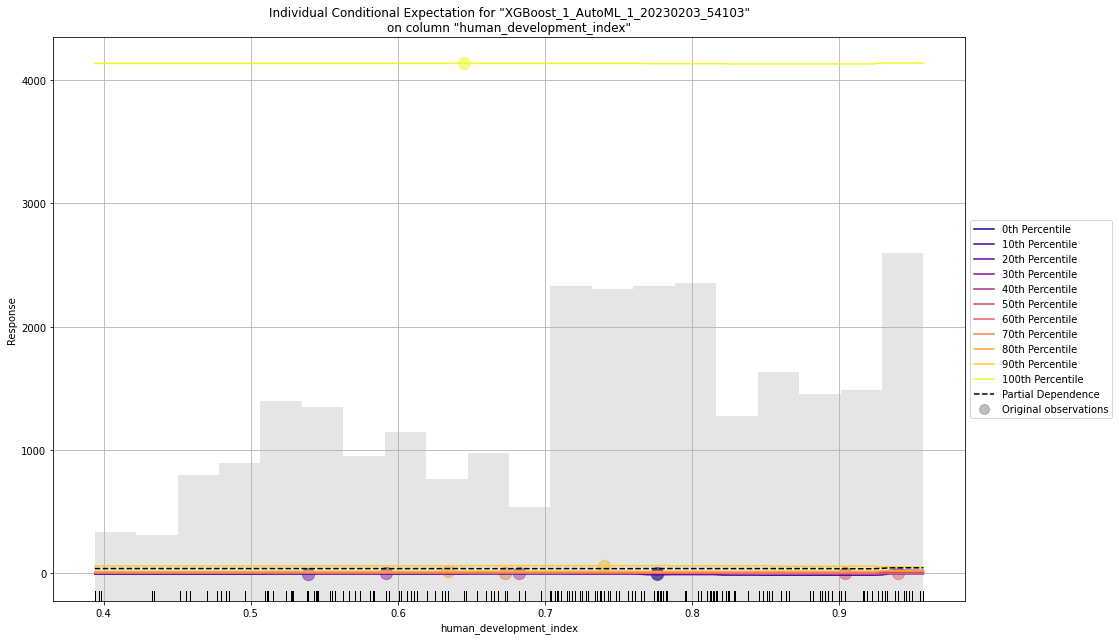

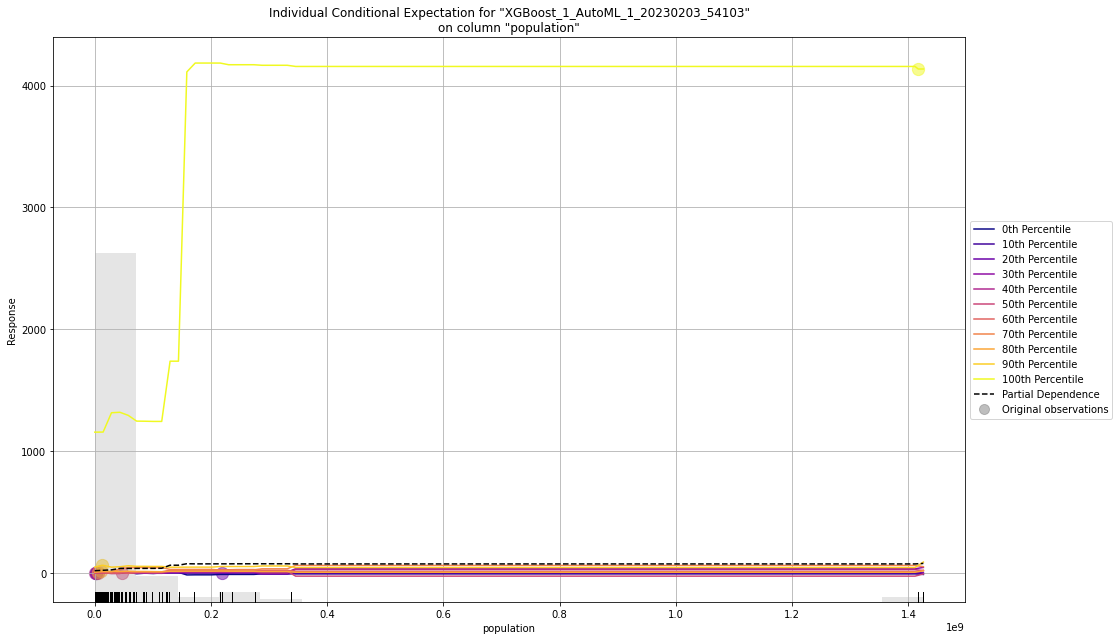

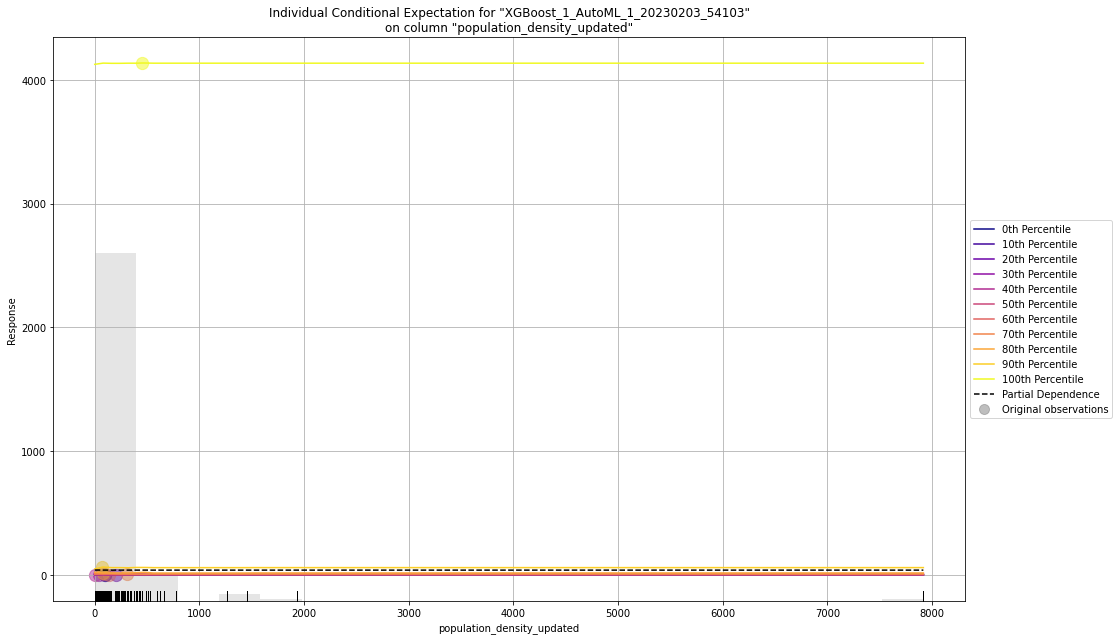

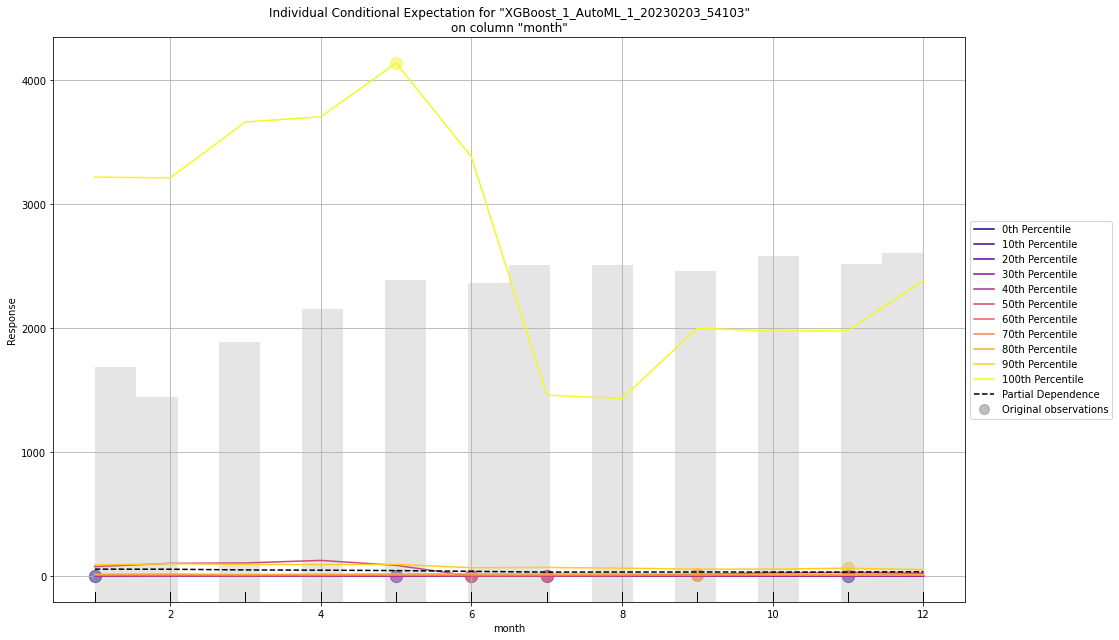

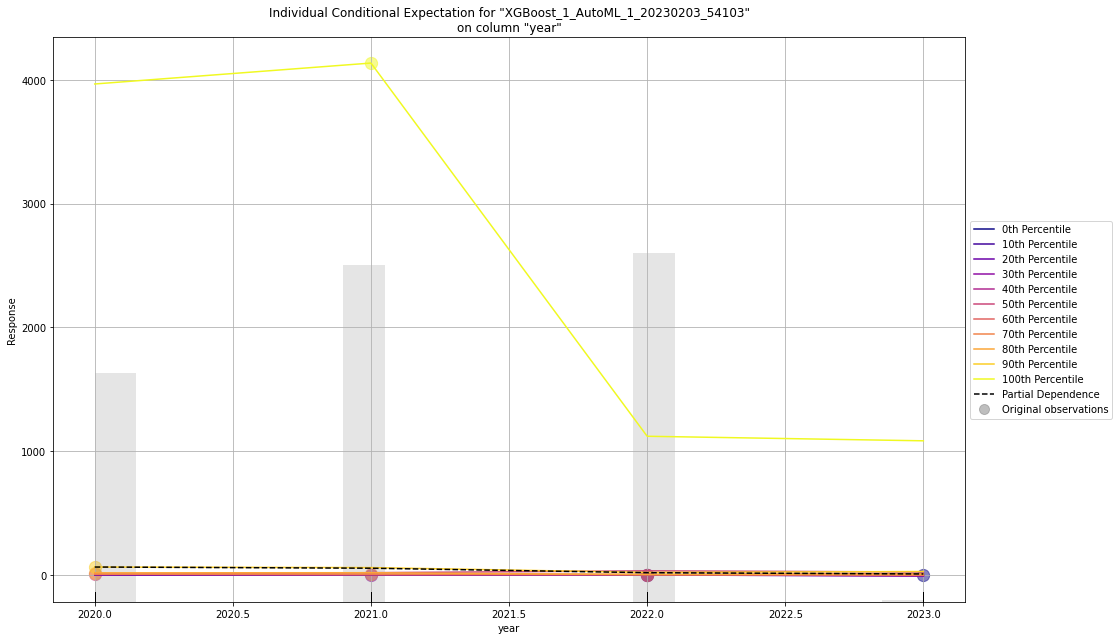

time: 20min 44s (started: 2023-02-03 06:33:01 +00:00)


In [27]:
#ICE Plot
for i in x:
  ice_plot = xgb.ice_plot(testH2O, i)
  ice_plot